# Comparison of TC hazard assessments

This notebook provides an interface to compare the TCHA 2018 with the existing benchmark hazard assessment (published in 2015). 

The new hazard assessment takes advantage of several upgrades to the underlying TCRM system, including a shift to indivisual events (enabling use of the Generalised Pareto Distribution over the Generalised Extreme Value distribution), a parametric model of radius to maximum wind and refinement of the landfall decay model to better suit observed decay rates in Australia. 



In [1]:
%matplotlib inline
from __future__ import print_function, division

In [37]:
import os
from os.path import join as pjoin
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.lines import Line2D

import cartopy.crs as ccrs
import cartopy.feature as feature
import shapely.geometry as sg


from netCDF4 import Dataset

from Utilities.config import ConfigParser
import seaborn as sns
sns.set_context("poster")
sns.set_style("whitegrid")

Start by setting the path to the hazard data for each assessment. We're primarily interested in the AEP wind speeds, so we point to the netCDF file holding the AEP wind speed data. 

In [3]:
tcha1_path = "/g/data/w85/TCRM_data/tcrm-v1/hazard/hazard.nc"
tcha2_path = "/g/data/w85/TCRM_data/tcrm-v2/hazard/hazard.nc"

tcha1 = Dataset(tcha1_path, 'r')
tcha2 = Dataset(tcha2_path, 'r')

Define functions to help intersect the different domains for the hazard assessments. The first TCHA had a larger extent, going well into the South Pacific Ocean (180E). 

In [4]:
def getExtent(ncobj):
    lon = ncobj.variables['lon'][:]
    lat = ncobj.variables['lat'][:]
    return (np.min(lon), np.max(lon), np.min(lat), np.max(lat))

def intersectDomain(ncobj1, ncobj2):
    lon1 = ncobj1.variables['lon'][:]
    lat1 = ncobj1.variables['lat'][:]
    lon2 = ncobj2.variables['lon'][:]
    lat2 = ncobj2.variables['lat'][:]
    extents1 = getExtent(ncobj1)
    extents2 = getExtent(ncobj2)
    
    idx1 = np.where((lon1 <= extents2[1]) & (lon1 >= extents2[0]))[0]
    jdy1 = np.where((lat1 <= extents2[3]) & (lat1 >= extents2[2]))[0]
    idx2 = np.where((lon2 <= extents1[1]) & (lon2 >= extents1[0]))[0]
    jdy2 = np.where((lat2 <= extents1[3]) & (lat2 >= extents1[2]))[0]
    return idx1, jdy1, idx2, jdy2

In [5]:
idx1, jdy1, idx2, jdy2 = intersectDomain(tcha1, tcha2)
lon1 = tcha1.variables['lon'][:]
lat1 = tcha1.variables['lat'][:]
lon2 = tcha2.variables['lon'][:]
lat2 = tcha2.variables['lat'][:]

In [6]:
xgrid1, ygrid1 = np.meshgrid(lon1[idx1], lat1[jdy1])
xgrid2, ygrid2 = np.meshgrid(lon2[idx2], lat2[jdy2])

In [ ]:
wspd1 = tcha1.variables['wspd'][:, jdy1, idx1]
wspd2 = tcha2.variables['wspd'][:, jdy2, idx2]
wspddiff = wspd2 - wspd1

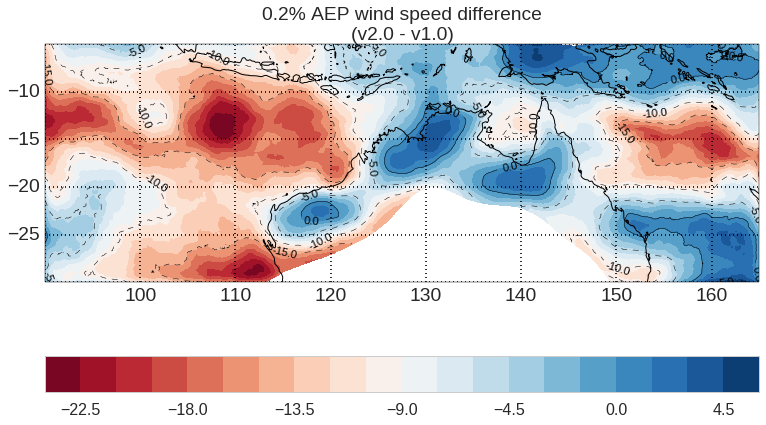

In [57]:
ax = plt.axes(projection=ccrs.PlateCarree())
cs = ax.contourf(xgrid1, ygrid1, wspddiff[10, :, :], 25, 
                 cmap='RdBu')
cl = ax.contour(xgrid1, ygrid1, wspddiff[10, :, :],[-15, -10, -5, 0,5, 10], linewidths=0.5, colors='k')
ax.coastlines(resolution='50m', color='black', linewidth=1)
plt.colorbar(cs, orientation="horizontal")
plt.clabel(cl, fmt="%0.1f",fontsize='xx-small')
xlocator = MultipleLocator(10)
ylocator = MultipleLocator(5)
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocator, ylocs=ylocator)
gl.xlabels_top = False
gl.ylabels_right = False
ax.set_title("0.2% AEP wind speed difference\n(v2.0 - v1.0)")

In [110]:
import io
import database
import pandas as pd


from Utilities.config import ConfigParser
from Utilities.maputils import find_index
from ipywidgets import interact, fixed, Dropdown, FloatSlider, interact_manual, interactive
import ipywidgets as widgets
from IPython.display import display, Image

import seaborn as sns
sns.set_context("poster")
sns.set_style("whitegrid")

In [111]:
configstr = """
[DataProcess]
InputFile=/home/547/cxa547/tcrm/input/Allstorms.ibtracs_wmo.v03r09.csv
Source=IBTRACS
StartSeason=1981
FilterSeasons=False

[Region]
; Domain for windfield and hazard calculation
gridLimit={'xMin':175.,'xMax':185.,'yMin':-23.0,'yMax':-13.0}
gridSpace={'x':1.0,'y':1.0}
gridInc={'x':1.0,'y':0.5}

[TrackGenerator]
NumSimulations=10000
YearsPerSimulation=1
SeasonSeed=68876543
TrackSeed=334825
TimeStep=1.0

[Input]
landmask = /home/547/cxa547/tcrm/input/landmask.nc
mslpfile = /home/547/cxa547/tcrm/MSLP/slp.day.ltm.nc
datasets = IBTRACS,LTMSLP

[Output]
Path=/g/data/w85/TCRM_data/tcrm-v2/

[Hazard]
Years=2,5,10,20,25,50,100,200,250,500,1000,2000,2500,5000
MinimumRecords=10
CalculateCI=False

[Logging]
LogFile=/g/data/w85/TCRM_data/tcrm-v2/log/tcrm-v2.log
LogLevel=INFO
Verbose=False

[IBTRACS]
; Input data file settings
url = ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r06/wmo/csv/Allstorms.ibtracs_wmo.v03r09.csv.gz
path = /home/547/cxa547/tcrm/input/
filename = Allstorms.ibtracs_wmo.v03r09.csv
columns = tcserialno,season,num,skip,skip,skip,date,skip,lat,lon,skip,pressure
fielddelimiter = ,
numberofheadinglines = 3
pressureunits = hPa
lengthunits = km
dateformat = %Y-%m-%d %H:%M:%S
speedunits = kph

[LTMSLP]
; MSLP climatology file settings
URL = ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/surface/slp.day.1981-2010.ltm.nc
path = /home/547/cxa547/tcrm/MSLP
filename = slp.day.ltm.nc

[Process]
DatFile=/g/data/w85/TCRM_data/tcrm-v2/process/dat/tcrm-v2.dat
ExcludePastProcessed=False
"""

In [112]:
config = ConfigParser()
config.readfp(io.BytesIO(configstr))

db = database.HazardDatabase(configstr)
locations = db.getLocations()
locNameList = list(locations['locName'])
outputPath = config.get('Output', 'Path')
years = np.array(config.get('Hazard', 'Years').split(',')).astype(int)

In [113]:
years

array([   2,    5,   10,   20,   25,   50,  100,  200,  250,  500, 1000,
       2000, 2500, 5000])

In [116]:
from PlotInterface.curves import SemilogRangeCompareCurve, saveFigure
def plotHazardCurve(locName):
    locId = locations['locId'][locations['locName']==locName][0]
    locLon = locations['locLon'][locations['locId']==locId][0]
    locLat = locations['locLat'][locations['locId']==locId][0]

    i1 = find_index(lon1[idx1], locLon)
    j1 = find_index(lat1[jdy1], locLat)
    i2 = find_index(lon2[idx2], locLon)
    j2 = find_index(lat2[jdy2], locLat)

    h1 = wspd1[:, j1, i1]
    h2 = wspd2[:, j2, i2]
    
    f = SemilogRangeCompareCurve()
    f.add(years, h1, h2, np.zeros(len(years)), np.zeros(len(years)), 
          xlabel="Average recurrence interval (years)",
          ylabel="Wind speed (m/s)",
          title="{0} ({1:.3f}, {2:.3f})".format(locName, locLon, locLat))
    f.plot()
    saveFigure(f, "hazardCurve.png")
    Image("hazardCurve.png")

In [117]:
w = interactive(plotHazardCurve, 
                locName=Dropdown(options=locNameList,
                                 description="Location"),
               )
display(w)

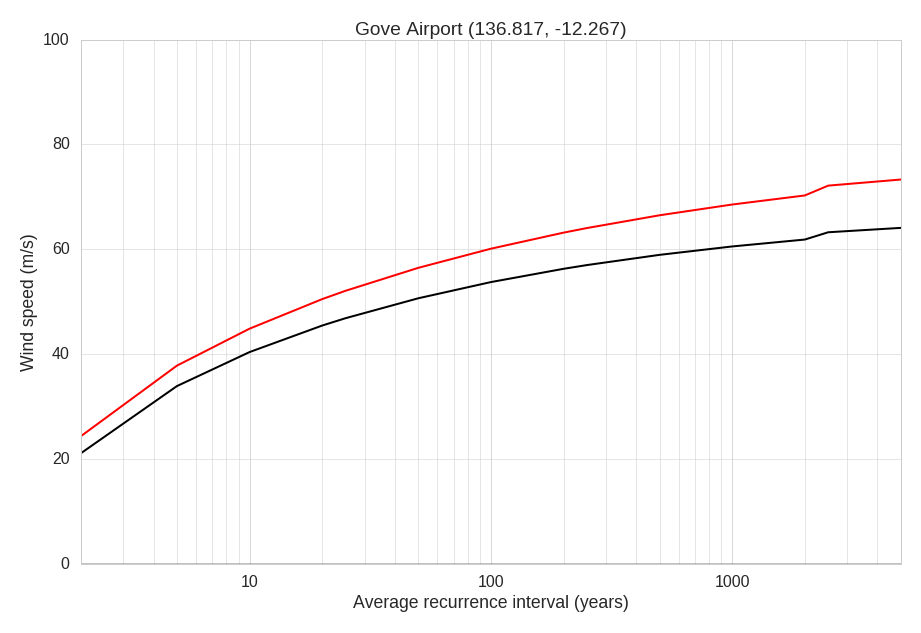

In [120]:
Image("hazardCurve.png")